# Generation of the masks
Based on the train.csv dataset, masks will be created to serve as ground truth for the model. Since the images are distorted and not costant a 100% overlap will be difficult. For now I will concentrate my data cleaning and preparation on the most costant images without to many artifacts, and try to overlap the masks the best I can. Once the training model is ready and went trough a virst validation, I will optimize the data cleaning process to obtain better masks. 
Using ipwidgets I am able to manually move the mask over the images and determine common coordinates for the images group (3,4, ...).


In [ ]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, Dropdown, Button, HBox, VBox, Output, Layout, Checkbox
from IPython.display import display


plt.rcParams["figure.dpi"] = 120



DATA_ROOT = Path("ECG_dataset/physionet-ecg-image-digitization")
TRAIN_CSV = Path("train_data/train.csv")
LONG_NPZ_PATH = Path("train_data/physionet_long_leads.npz")
LEADS_NPZ_PATH = Path("train_data/physionet_leads_small.npz")
LONG_MASKS_NPZ_PATH = Path("train_data/physionet_long_masks.npz")
LEAD_MASKS_NPZ_PATH = Path("train_data/physionet_leads_small_masks.npz")
LONG_ALIGN_JSON = Path("train_data/long_lead_alignment.json")
LEAD_ALIGN_JSON = Path("train_data/lead_small_alignment.json")


train_df = pd.read_csv(TRAIN_CSV)
train_df["id"] = train_df["id"].astype(str)

long_npz = np.load(LONG_NPZ_PATH, allow_pickle=True)
leads_npz = np.load(LEADS_NPZ_PATH, allow_pickle=True)

print("Num long-lead images:", len(long_npz.files))
print("Num small-lead sets:", len(leads_npz.files))
print("Example long key:", long_npz.files[:5])
print("Example small key:", leads_npz.files[:5])

if LONG_ALIGN_JSON.exists():
    with open(LONG_ALIGN_JSON, "r") as f:
        long_alignment = json.load(f)
else:
    long_alignment = {}

if LEAD_ALIGN_JSON.exists():
    with open(LEAD_ALIGN_JSON, "r") as f:
        lead_alignment = json.load(f)
else:
    lead_alignment = {}

Num long-lead images: 12
Num small-lead sets: 12
Example long key: ['12_1006867983', '12_1006427285', '12_1012423188', '4_1006867983', '4_1006427285']
Example small key: ['12_1006867983', '12_1006427285', '12_1012423188', '4_1006867983', '4_1006427285']


In [ ]:
def parse_key(key: str):
    """
    Keys in the npz are like '11_1006867983'.
    Returns (group, rec_id), where group is '3','4','11','12'.
    """
    group, rec_id = key.split("_", 1)
    return group, rec_id

LEAD_ORDER = ["I", "II", "III",
              "aVR", "aVL", "aVF",
              "V1", "V2", "V3", "V4", "V5", "V6"]
some_key = leads_npz.files[0]
num_panels = len(leads_npz[some_key])
print("LEAD_ORDER length:", len(LEAD_ORDER), "| panels in npz for one key:", num_panels)
if len(LEAD_ORDER) != num_panels:
    print("WARNING: LEAD_ORDER length does not match number of panels.")

LEAD_ORDER length: 12 | panels in npz for one key: 12


In [ ]:
def get_fs(rec_id: str) -> float:
    """Look up sampling frequency fs in training csv dataset."""
    rec_id = str(rec_id)
    row = train_df.loc[train_df["id"] == rec_id]
    if row.empty:
        raise KeyError(f"rec_id={rec_id} not found in train.csv")
    return float(row["fs"].iloc[0])


def find_waveform_csv(rec_id: str) -> Path:
    """
    Try common paths first; if not found, do a recursive search under DATA_ROOT.
    I have more testing data in various places, if you have only one place, you can simplify this function.
    """
    rec_id = str(rec_id)

    candidates = [
        DATA_ROOT / "train_waveforms" / f"{rec_id}.csv",
        DATA_ROOT / "waveforms" / f"{rec_id}.csv",
        DATA_ROOT / "train" / rec_id / f"{rec_id}.csv",
        DATA_ROOT / "train" / f"{rec_id}.csv",
        DATA_ROOT / rec_id / f"{rec_id}.csv",
    ]

    for p in candidates:
        if p.exists():
            return p

    matches = list(DATA_ROOT.rglob(f"{rec_id}.csv"))
    if matches:
        return matches[0]

    raise FileNotFoundError(
        f"Could not find CSV for rec_id={rec_id}. Tried:\n" +
        "\n".join(str(p) for p in candidates)
    )


def load_raw_ecg(rec_id: str) -> pd.DataFrame:
    """Load the raw multi-lead ECG signal."""
    csv_path = find_waveform_csv(rec_id)
    df = pd.read_csv(csv_path)
    return df


def clean_signal(signal: np.ndarray) -> np.ndarray:
    """
    Minimal cleaning to test, will be updated later once I have more informations on the data itself:
    - cast to float
    - replace inf with NaN
    - interpolate NaNs
    """
    s = pd.Series(signal.astype(float))
    s = s.replace([np.inf, -np.inf], np.nan)
    s = s.interpolate(limit_direction="both")
    return s.to_numpy()


def extract_lead(df: pd.DataFrame, lead_name: str) -> np.ndarray:
    """
    Extract a specific lead column from the dataframe.
    Tries several common variants of the name.
    """
    if lead_name in df.columns:
        return df[lead_name].astype(float).to_numpy()

    name_map = {
        "I":   ["I", "Lead I", "lead_I"],
        "II":  ["II", "Lead II", "lead_II"],
        "III": ["III", "Lead III", "lead_III"],
        "aVR": ["aVR", "avr", "AVR"],
        "aVL": ["aVL", "avl", "AVL"],
        "aVF": ["aVF", "avf", "AVF"],
    }

    candidates = name_map.get(lead_name, []) + [lead_name.lower(), lead_name.upper()]
    for cand in candidates:
        if cand in df.columns:
            return df[cand].astype(float).to_numpy()

    raise KeyError(f"Lead '{lead_name}' not found. Columns: {', '.join(df.columns)}")

In [4]:
def draw_segment(mask: np.ndarray, x0: float, y0: float, x1: float, y1: float, thickness: int = 1):
    """
    Draw a line segment between (x0, y0) and (x1, y1) on a 2D mask
    using simple linear interpolation and rounding.
    Skips segments with non-finite endpoints.
    """
    H, W = mask.shape

    if not np.all(np.isfinite([x0, y0, x1, y1])):
        return

    steps = int(max(abs(x1 - x0), abs(y1 - y0))) + 1
    if steps < 2:
        steps = 2

    xs = np.linspace(x0, x1, steps)
    ys = np.linspace(y0, y1, steps)

    xs = np.clip(xs, 0, W - 1)
    ys = np.clip(ys, 0, H - 1)

    xs = np.nan_to_num(xs, nan=0.0)
    ys = np.nan_to_num(ys, nan=0.0)

    xs = np.round(xs).astype(int)
    ys = np.round(ys).astype(int)

    for x, y in zip(xs, ys):
        for dy in range(-thickness // 2, thickness // 2 + 1):
            yy = y + dy
            if 0 <= yy < H:
                mask[yy, x] = 1


def signal_to_mask(
    signal: np.ndarray,
    fs: float,
    img_shape,
    seconds: float,
    thickness: int = 2,
    x_offset: int = 0,
    y_offset: int = 0,
    amp_scale: float = 0.4,
    flip_x: bool = False,
) -> np.ndarray:
    """
    Convert a 1D ECG signal into a binary mask aligned to a given image size.

    seconds  : duration to map onto full image width (10 for long strip, 2.5 for small leads)
    x_offset : horizontal pixel offset (group-wise fine alignment)
    y_offset : vertical pixel offset (group-wise fine alignment)
    amp_scale: how tall the spikes look (0.2..0.5 is a good range)
    """
    H, W = img_shape

    n_samples = int(round(seconds * fs))
    if n_samples > len(signal):
        n_samples = len(signal)

    sig = clean_signal(signal[:n_samples])

    sig_centered = sig - np.median(sig)

    p99 = np.percentile(np.abs(sig_centered), 99)
    if p99 == 0:
        p99 = 1.0

    sig_norm = sig_centered / p99        
    sig_norm = np.clip(sig_norm, -1.0, 1.0)

    usable_height = (H / 2.0) - 4  
    if usable_height <= 0:
        usable_height = H / 2.0

    midline = H / 2.0 + y_offset
    direction = -1.0          
    if flip_x:                
        direction = 1.0 
    y_float = midline - sig_norm * usable_height * amp_scale
    y_float = np.clip(y_float, 0, H - 1)

    x_float = np.linspace(0, W - 1, len(sig)) + x_offset
    mask = np.zeros((H, W), dtype=np.uint8)
    for i in range(len(sig) - 1):
        draw_segment(mask, x_float[i], y_float[i], x_float[i + 1], y_float[i + 1], thickness=thickness)

    return mask


def build_overlay(mask: np.ndarray,
                  color=(0.0, 1.0, 0.0),
                  alpha: float = 0.7) -> np.ndarray:
    """Binary mask -> RGBA overlay with a given color and alpha."""
    H, W = mask.shape
    overlay = np.zeros((H, W, 4), dtype=float)
    yy, xx = np.where(mask > 0)
    overlay[yy, xx, 0] = color[0]
    overlay[yy, xx, 1] = color[1]
    overlay[yy, xx, 2] = color[2]
    overlay[yy, xx, 3] = alpha
    return overlay

Test long key: 12_1006867983 | group: 12 | rec_id: 1006867983


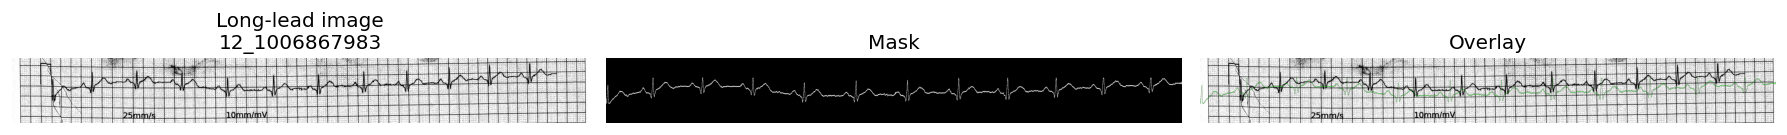

In [5]:
test_key_long = long_npz.files[0]
group, rec_id = parse_key(test_key_long)

print("Test long key:", test_key_long, "| group:", group, "| rec_id:", rec_id)

img = long_npz[test_key_long]
if img.ndim == 3:
    img_gray = img.mean(axis=-1)
else:
    img_gray = img

fs = get_fs(rec_id)
df_sig = load_raw_ecg(rec_id)
lead_ii = extract_lead(df_sig, "II")

offs = long_alignment.get(group, {"x": 0, "y": 0})
x_off = int(offs.get("x", 0))
y_off = int(offs.get("y", 0))

mask = signal_to_mask(
    signal=lead_ii,
    fs=fs,
    img_shape=img_gray.shape,
    seconds=10.0,
    x_offset=x_off,
    y_offset=y_off,
    thickness=2,
    amp_scale=0.4,
)

overlay = build_overlay(mask, color=(0.0, 1.0, 0.0), alpha=0.7)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(img_gray, cmap="gray")
axes[0].set_title(f"Long-lead image\n{test_key_long}")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

axes[2].imshow(img_gray, cmap="gray")
axes[2].imshow(overlay)
axes[2].set_title("Overlay")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:

def make_long_lead_alignment_widget(key: str):
    """
    Alignment UI for the 10s long lead II strip.
    Offsets are saved per group (3,4,11,12), shared by all keys in that group!!!!
    """
    global long_alignment

    group, rec_id = parse_key(key)
    img = long_npz[key]
    if img.ndim == 3:
        img_gray = img.mean(axis=-1)
    else:
        img_gray = img

    fs = get_fs(rec_id)
    df_sig = load_raw_ecg(rec_id)
    lead_ii = extract_lead(df_sig, "II")

    defaults = long_alignment.get(group, {"x": 0, "y": 0})
    default_x = int(defaults.get("x", 0))
    default_y = int(defaults.get("y", 0))
    default_flip = bool(defaults.get("flip_x", False))


    slider_x = IntSlider(
        value=default_x, min=-100, max=100, step=1,
        description="x offset", continuous_update=True,
        layout=Layout(width="400px")
    )
    slider_y = IntSlider(
        value=default_y, min=-50, max=50, step=1,
        description="y offset", continuous_update=True,
        layout=Layout(width="400px")
    )
    flip_checkbox = Checkbox(
    value=default_flip,
    description="Mirror horizontally",
    indent=False,
)
    btn_save = Button(description="Save offset", button_style="success")
    out = Output()

    def redraw(_=None):
        with out:
            out.clear_output(wait=True)

            mask = signal_to_mask(
                signal=lead_ii,
                fs=fs,
                img_shape=img_gray.shape,
                seconds=10.0,
                x_offset=slider_x.value,
                y_offset=slider_y.value,
                thickness=2,
                amp_scale=0.4,
                flip_x=flip_checkbox.value,
            )
            overlay = build_overlay(mask, color=(0.0, 1.0, 0.0), alpha=0.7)

            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].imshow(img_gray, cmap="gray")
            axes[0].set_title(f"Long lead II\n{key} (group {group})")
            axes[0].axis("off")

            axes[1].imshow(mask, cmap="gray")
            axes[1].set_title("Mask")
            axes[1].axis("off")

            axes[2].imshow(img_gray, cmap="gray")
            axes[2].imshow(overlay)
            axes[2].set_title("Overlay")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

    def on_save(_):
        long_alignment[group] = {"x": slider_x.value, "y": slider_y.value, "flip_x": bool(flip_checkbox.value)}
        with open(LONG_ALIGN_JSON, "w") as f:
            json.dump(long_alignment, f, indent=2)
        with out:
            print(f"Saved LONG-lead offsets for group {group}: "
                  f"x={slider_x.value}, y={slider_y.value} "
                  f"(applies to all '{group}_*' long strips)")

    slider_x.observe(redraw, names="value")
    slider_y.observe(redraw, names="value")
    flip_checkbox.observe(redraw, names="value")
    btn_save.on_click(on_save)

    redraw()
    display(VBox([HBox([slider_x, slider_y, flip_checkbox, btn_save]), out]))


long_key_dropdown = Dropdown(
    options=sorted(long_npz.files),
    description="Long key:",
    layout=Layout(width="400px")
)

def on_long_key_change(change):
    if change["name"] == "value" and change["new"] is not None:
        make_long_lead_alignment_widget(change["new"])

long_key_dropdown.observe(on_long_key_change, names="value")
display(long_key_dropdown)

Dropdown(description='Long key:', layout=Layout(width='400px'), options=('11_1006427285', '11_1006867983', '11…

In [7]:
from ipywidgets import IntSlider, Dropdown, Button, HBox, VBox, Output, Layout
from IPython.display import display

def make_small_lead_alignment_widget(key: str, lead_name: str):
    """
    Alignment UI for one 2.5s small lead panel.
    Offsets are saved per group (3,4,11,12), shared by all keys in that group.
    """
    global lead_alignment

    group, rec_id = parse_key(key)

    panels = leads_npz[key]         
    lead_idx = LEAD_ORDER.index(lead_name)

    lead_img = np.array(panels[lead_idx])
    if lead_img.ndim == 3:
        lead_img_gray = lead_img.mean(axis=-1)
    else:
        lead_img_gray = lead_img

    fs = get_fs(rec_id)
    df_sig = load_raw_ecg(rec_id)
    signal = extract_lead(df_sig, lead_name)

    defaults = lead_alignment.get(group, {"x": 0, "y": 0})
    default_x = int(defaults.get("x", 0))
    default_y = int(defaults.get("y", 0))
    default_flip = bool(defaults.get("flip_x", False))

    slider_x = IntSlider(
        value=default_x, min=-80, max=80, step=1,
        description="x offset", continuous_update=True,
        layout=Layout(width="400px")
    )
    slider_y = IntSlider(
        value=default_y, min=-40, max=40, step=1,
        description="y offset", continuous_update=True,
        layout=Layout(width="400px")
    )
    flip_checkbox = Checkbox(
    value=default_flip,
    description="Mirror horizontally",
    indent=False,
    )
    btn_save = Button(description="Save offset", button_style="success")
    out = Output()

    def redraw(_=None):
        with out:
            out.clear_output(wait=True)

            mask = signal_to_mask(
                signal=signal,
                fs=fs,
                img_shape=lead_img_gray.shape,
                seconds=2.5,
                x_offset=slider_x.value,
                y_offset=slider_y.value,
                thickness=2,
                amp_scale=0.4,
                flip_x=flip_checkbox.value,
            )
            overlay = build_overlay(mask, color=(0.0, 1.0, 0.0), alpha=0.7)

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(lead_img_gray, cmap="gray")
            axes[0].set_title(f"Lead image: {lead_name}\n{key} (group {group})")
            axes[0].axis("off")

            axes[1].imshow(mask, cmap="gray")
            axes[1].set_title("Mask")
            axes[1].axis("off")

            axes[2].imshow(lead_img_gray, cmap="gray")
            axes[2].imshow(overlay)
            axes[2].set_title("Overlay")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

    def on_save(_):
        lead_alignment[group] = {"x": slider_x.value, "y": slider_y.value, "flip_x": bool(flip_checkbox.value)}
        with open(LEAD_ALIGN_JSON, "w") as f:
            json.dump(lead_alignment, f, indent=2)
        with out:
            print(
                f"Saved SMALL-lead offsets for group {group}: "
                f"x={slider_x.value}, y={slider_y.value} "
                f"(applies to all '{group}_*' small leads)"
            )

    slider_x.observe(redraw, names="value")
    slider_y.observe(redraw, names="value")
    flip_checkbox.observe(redraw, names="value")
    btn_save.on_click(on_save)

    redraw()
    display(VBox([HBox([slider_x, slider_y, flip_checkbox, btn_save]), out]))


small_key_dropdown = Dropdown(
    options=sorted(leads_npz.files),
    description="Small key:",
    layout=Layout(width="400px")
)

lead_name_dropdown = Dropdown(
    options=LEAD_ORDER,        
    value=LEAD_ORDER[0],
    description="Lead:",
    layout=Layout(width="200px")
)

def on_small_change(_):
    key = small_key_dropdown.value
    lead_name = lead_name_dropdown.value
    if key is not None and lead_name is not None:
        make_small_lead_alignment_widget(key, lead_name)

small_key_dropdown.observe(on_small_change, names="value")
lead_name_dropdown.observe(on_small_change, names="value")

display(HBox([small_key_dropdown, lead_name_dropdown]))

In [8]:
# Reload alignment in case you just edited it with the widgets
if LONG_ALIGN_JSON.exists():
    with open(LONG_ALIGN_JSON, "r") as f:
        long_alignment = json.load(f)
else:
    long_alignment = {}

long_masks = {}

for key in long_npz.files:
    group, rec_id = parse_key(key)
    img = long_npz[key]
    if img.ndim == 3:
        img_gray = img.mean(axis=-1)
    else:
        img_gray = img

    try:
        fs = get_fs(rec_id)
        df_sig = load_raw_ecg(rec_id)
        lead_ii = extract_lead(df_sig, "II")
    except Exception as e:
        print(f"[SKIP] long {key}: {e}")
        continue

    offs = long_alignment.get(group, {"x": 0, "y": 0})
    x_off = int(offs.get("x", 0))
    y_off = int(offs.get("y", 0))
    flip_x = bool(offs.get("flip_x", False))

    mask = signal_to_mask(
        signal=lead_ii,
        fs=fs,
        img_shape=img_gray.shape,
        seconds=10.0,
        x_offset=x_off,
        y_offset=y_off,
        thickness=2,
        amp_scale=0.4,
        flip_x=flip_x,
    )

    long_masks[key] = mask.astype(np.uint8)

print("Generated long-lead masks for", len(long_masks), "records")

np.savez_compressed(LONG_MASKS_NPZ_PATH, **long_masks)
print("Saved long masks to:", LONG_MASKS_NPZ_PATH.resolve())

Generated long-lead masks for 12 records
Saved long masks to: /Users/nicolaspedrazzi/Desktop/Dev/ML/ECG_project/train_data/physionet_long_masks.npz


In [9]:
# Reload alignment in case you just edited it with the widgets
if LEAD_ALIGN_JSON.exists():
    with open(LEAD_ALIGN_JSON, "r") as f:
        lead_alignment = json.load(f)
else:
    lead_alignment = {}

lead_masks = {}

for key in leads_npz.files:
    group, rec_id = parse_key(key)
    panels = leads_npz[key]

    try:
        fs = get_fs(rec_id)
        df_sig = load_raw_ecg(rec_id)
    except Exception as e:
        print(f"[SKIP] small {key}: {e}")
        continue

    offs = lead_alignment.get(group, {"x": 0, "y": 0})
    x_off = int(offs.get("x", 0))
    y_off = int(offs.get("y", 0))
    flip_x = bool(offs.get("flip_x", False))

    for idx, panel in enumerate(panels):
        img = np.array(panel)
        if img.ndim == 3:
            img_gray = img.mean(axis=-1)
        else:
            img_gray = img

        lead_name = LEAD_ORDER[idx]

        try:
            signal = extract_lead(df_sig, lead_name)
        except Exception as e:
            print(f"[SKIP] {key} lead {lead_name}: {e}")
            continue

        mask = signal_to_mask(
            signal=signal,
            fs=fs,
            img_shape=img_gray.shape,
            seconds=2.5,
            x_offset=x_off,
            y_offset=y_off,
            thickness=2,
            amp_scale=0.4,
            flip_x=flip_x,
        )

        mask_key = f"{key}_{lead_name}"   # e.g. "11_1006867983_II"
        lead_masks[mask_key] = mask.astype(np.uint8)

print("Generated small-lead masks for", len(lead_masks), "panels")

np.savez_compressed(LEAD_MASKS_NPZ_PATH, **lead_masks)
print("Saved small-lead masks to:", LEAD_MASKS_NPZ_PATH.resolve())

Generated small-lead masks for 144 panels
Saved small-lead masks to: /Users/nicolaspedrazzi/Desktop/Dev/ML/ECG_project/train_data/physionet_leads_small_masks.npz


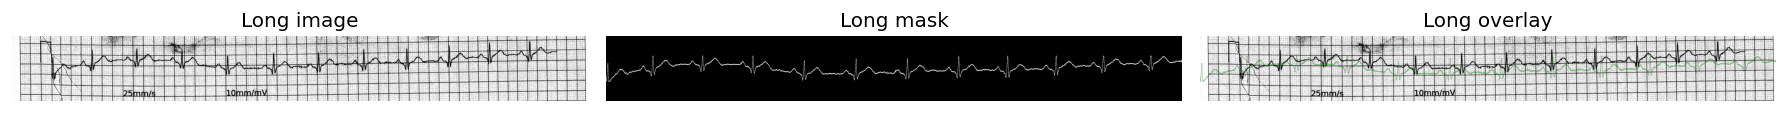

Example small mask key: 12_1006867983_I


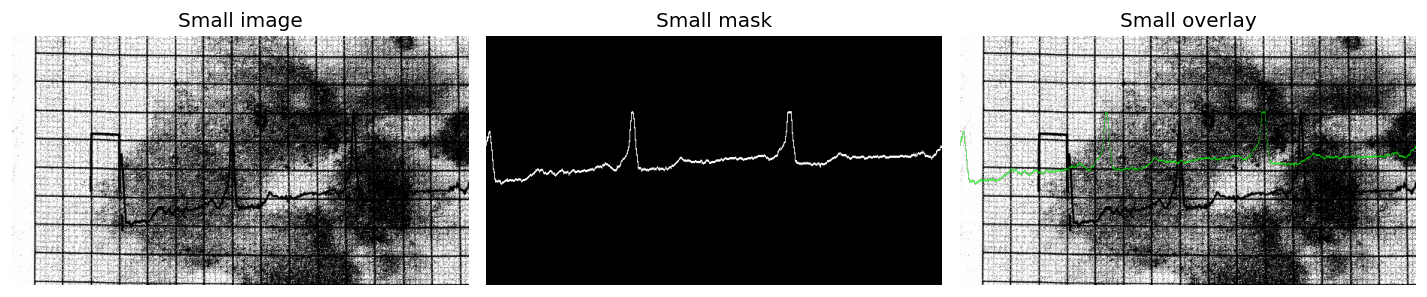

In [ ]:
#Let's control everything worked by visualizing some masks and overlays
long_masks_npz = np.load(LONG_MASKS_NPZ_PATH, allow_pickle=True)
key = list(long_masks_npz.files)[0]
img = long_npz[key]
if img.ndim == 3:
    img_gray = img.mean(axis=-1)
else:
    img_gray = img
mask = long_masks_npz[key]
overlay = build_overlay(mask, color=(0.0, 1.0, 0.0), alpha=0.7)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(img_gray, cmap="gray"); axes[0].set_title("Long image"); axes[0].axis("off")
axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Long mask"); axes[1].axis("off")
axes[2].imshow(img_gray, cmap="gray"); axes[2].imshow(overlay); axes[2].set_title("Long overlay"); axes[2].axis("off")
plt.tight_layout(); plt.show()


lead_masks_npz = np.load(LEAD_MASKS_NPZ_PATH, allow_pickle=True)
mask_key = list(lead_masks_npz.files)[0]
print("Example small mask key:", mask_key)
small_base_key, lead_name = mask_key.rsplit("_", 1)
img_panels = leads_npz[small_base_key]
lead_idx = LEAD_ORDER.index(lead_name)
img_small = np.array(img_panels[lead_idx])
if img_small.ndim == 3:
    img_small_gray = img_small.mean(axis=-1)
else:
    img_small_gray = img_small
mask_small = lead_masks_npz[mask_key]
overlay_small = build_overlay(mask_small, color=(0.0, 1.0, 0.0), alpha=0.7)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img_small_gray, cmap="gray"); axes[0].set_title("Small image"); axes[0].axis("off")
axes[1].imshow(mask_small, cmap="gray"); axes[1].set_title("Small mask"); axes[1].axis("off")
axes[2].imshow(img_small_gray, cmap="gray"); axes[2].imshow(overlay_small); axes[2].set_title("Small overlay"); axes[2].axis("off")
plt.tight_layout(); plt.show()